In [ ]:
%%bash

pip install -q kaggle
mkdir -p ~/.kaggle
cp drive/MyDrive/kaggle.json ~/.kaggle/
chmod 600 /root/.kaggle/kaggle.json
kaggle datasets download -d amanrajbose/normal-vs-military-vehicles
unzip normal-vs-military-vehicles.zip

# Normal VS Military Vechicles



## Importing Modules

In [2]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import albumentations as A
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
  import warnings
  warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Preporcessing

In [3]:
def print_in_color(txt_msg, fore_tupple=(0, 255, 255), back_tupple=(100, 100, 100)):
  rf, gf, bf = fore_tupple
  rb, gb, bb = back_tupple
  msg = '{0}' + txt_msg
  mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
  print(msg .format(mat), flush=True)
  print('\33[0m', flush=True)
  return

In [4]:
def plot_label_count(df, plot_title):
  column = 'labels'
  xaxis_label = 'CLASS'
  yaxis_label = 'IMAGE COUNT'
  vcounts = df[column].value_counts()
  labels = vcounts.keys().tolist()
  values = vcounts.tolist()
  lcount = len(labels)
  if lcount > 55:
    print_in_color("The Number of labels > 55, no plot will be produced")
  else:
    width = lcount * 4
    width = np.min([width, 20])
    plt.figure(figsize=(width, 5))
    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    plt.bar(labels, values)
    plt.title(plot_title, fontsize=24, color='blue')
    plt.xticks(rotation=90, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(xaxis_label, fontdict=form)
    plt.ylabel(yaxis_label, fontdict=form)
    if lcount >= 8:
      rotation = 'vertical'
    else:
      rotation = 'horizontal'
    
    for i in range(lcount):
      plt.text(i, values[i]/2, str(values[i]), fontsize=12, rotation=rotation, color='yellow', ha='center')
    plt.show()

In [5]:
def make_dataframes(train_dir,test_dir, val_dir, limiter):
    bad_images=[]
    if test_dir == None and val_dir==None:
        dirlist=[train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist=[train_dir,  val_dir]
        names=['train', 'valid']
    elif val_dir == None:
        dirlist=[train_dir,  test_dir]
        names=['train', 'test'] 
    else:
        dirlist=[train_dir, test_dir, val_dir]
        names=['train','test', 'valid']
    ht=0
    wt=0  
    total_good_files=0
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            good_file_count=0
            classpath=os.path.join(d, klass)
            if os.path.isdir(classpath):
                flist=sorted(os.listdir(classpath)) 
                if limiter != None:
                    if limiter <len(flist):
                        flist=np.random.choice(flist, limiter, replace=False)
                desc=f'{name:6s}-{klass:25s}'
                for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                    fpath=os.path.join(classpath,f)
                    try: # check if image files are defective if so do not include in dataframe
                        img=cv2.imread(fpath)
                        h=img.shape[0]
                        w=img.shape[1]
                        ht +=h
                        wt += w                    
                        good_file_count +=1   
                        total_good_files +=1
                        filepaths.append(fpath)
                        labels.append(klass)

                    except:
                        bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            if test_dir == None and val_dir == None:
                pdf=df
                train_df, dummy_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None:
                pdf=df
                train_df,test_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            elif val_dir == None:                            
                pdf=df                
                train_df,valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else:
                train_df= df
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=100, replace=False)
    # calculate the average image height and with 
    have=int(ht/total_good_files)
    wave=int(wt/total_good_files)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    if len(bad_images) == 0:
        print_in_color('All image files were properly processed and used in the dataframes')
    else:
        print_in_color(f'the are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)                       
    plot_title='Images per Label in train set'
    plot_label_count (train_df,  plot_title)
    return train_df, test_df, valid_df, classes, class_count, max(counts), min(counts), have, wave

In [6]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count


In [7]:
def balance(df, n,column, working_dir, img_size):
    def get_augmented_image(image):
        width=int(image.shape[1]*.8)
        height=int(image.shape[0]*.8)
        transform= A.Compose([
            A.HorizontalFlip(p=.5),
            A.Rotate(limit=30, p=.25),
            A.RandomBrightnessContrast(p=.5),
            A.RandomGamma(p=.5),
            A.RandomCrop(width=width, height=height, p=.25) ])    
        return transform(image=image)['image']
    def dummy(image):
        return image

    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0    
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images            
            desc=f'augmenting class {label}'
            for i in tqdm(range(delta), ncols=120, unit='files', colour='blue',desc=desc):
                j= i % sample_count
                img_path=group['filepaths'].iloc[j]
                img=cv2.imread(img_path)
                img=get_augmented_image(img)
                fname=os.path.basename(img_path)
                fname='aug' +str(i) +'-' +fname
                dest_path=os.path.join(target_dir, fname)                
                cv2.imwrite(dest_path, img)
                aug_img_count +=1
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

In [8]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels    
    return train_gen, test_gen, valid_gen, test_steps

In [9]:
def show_image_samples(gen ):
    msg='Below are some example training images'
    print_in_color(msg)
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [10]:
def F1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', F1_score, 'AUC']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

In [12]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?                
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

In [13]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    tf1=tr_data.history['F1_score']
    vf1=tr_data.history['val_F1_score']    
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    indexf1=np.argmax(vf1)
    vf1_highest=vf1[indexf1]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=3, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    axes[2].plot (Epochs,tf1,'r',label= 'Training F1 score')    
    axes[2].plot (Epochs,vf1,'g',label= 'Validation F1 score')
    index_tf1=np.argmax(tf1)#  this is the epoch with the highest training F1 score
    tf1max=tf1[index_tf1]
    index_vf1=np.argmax(vf1)# thisiis the epoch with the highest validation F1 score
    vf1max=vf1[index_vf1]
    axes[2].scatter(index_vf1+1 +start_epoch,vf1max, s=150, c= 'blue', label=vc_label)    
    axes[2].scatter(Epochs, tf1, s=100, c='red')
    axes[2].set_title('Training and Validation F1 score')
    axes[2].set_xlabel('Epochs', fontsize=18)
    axes[2].set_ylabel('F1  score', fontsize=18)
    axes[2].legend()    
    plt.tight_layout    
    plt.show()
    return 

In [14]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

In [15]:
def print_errors(error_list, dilimter):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)>50:
            print_in_color('There were over 50 misclassifications, the error list will not be printed')
        else:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^50s}{1:^50s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]                
                split=fpath.split(delimiter)                 
                slength=len(split)
                f=split[slength-2]+ '-' + split[slength-1]                
                print(f'{f:^50s}{error_pred_list[i]:^50s}')

In [16]:
def show_misclassification(error_list, error_pred_list, test_gen, delimiter):
    if len(error_list) == 0:
        print_in_color('there were no errors in predicting the test images')    
    else:
        if len(error_list)<10:
            length=len(error_list)
        else:
            length = 10 # show 10 images        
        msg='The images below show 10 misclassified test images on left and an example of an image in the  misclassified class'
        print_in_color(msg)
        test_files=test_gen.filenames
        plt.figure(figsize=(15, length * 5))
        for i in range(length):
            fpath=error_list[i] 
            test_img=plt.imread(fpath)
            pred_class= error_pred_list[i]
            # find a test file that is the same class as the pred_class
            for f in test_gen.filenames:
                split=list(f.split(delimiter))                
                klass=split[len(split)-2]
                if klass == pred_class:
                    pred_img_path= f      
            pred_img=plt.imread(pred_img_path)
            for j in range(2):   
                k=i*2 + j + 1            
                plt.subplot(length, 2, k)
                plt.axis('off')
                if j == 0:
                    plt.imshow(test_img)
                    split=fpath.split(delimiter)
                    slength=len(split)
                    #print (split)
                    title=split[slength-2]+ '-' + split[slength-1]
                    title='TEST IMAGE\n'+ title
                    plt.title(title, color='blue', fontsize=16)
                else:                
                    plt.imshow(pred_img)
                    split=pred_img_path.split(delimiter)
                    slength=len(split)
                    title=split[slength-2]+ '-' + split[slength-1]
                    title='PREDICTED CLASS EXAMPLE\n'+ title
                    plt.title(title, color='blue', fontsize=16)
        plt.show()

In [17]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '-' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

In [18]:
def set_image_size(have, wave):
        if have<= 224 and wave <= 224:
            img_size=(have, wave)
        else:
            if have>= wave:
                img_size =(224, int (224*wave/have))
            else:
                img_size=(int(224* have/wave))  
            return img_size

In [19]:
def auto_balance(train_df, img_size,max_samples, min_samples,  working_dir):
    msg='enter the number of images you want to have in each class of the train data set'
    max_images=int(input(msg))
    msg='enter the minimum number of images a class must have to be included in the train data set'
    min_images = int(input(msg)) 
    train_df, classes, class_count=trim (train_df, max_images, min_images, 'labels') 
    train_df=balance(train_df, max_images, 'labels', working_dir, img_size)    
    plot_title='Images per Label after Auto Balance of train data set'
    plot_label_count (train_df,  plot_title)
    return train_df

In [20]:
def manual_balance(train_df,img_size, max_samples, min_samples, working_dir):
    msg = f' maximum images in a class is {max_samples}, minimum images in a class is {min_samples}'
    print_in_color(msg)
    msg=' if you want to trim the train set so no class has more than n images\n enter the maximun number of images allowed in a class or press enter to not trim'
    ans=input(msg)
    if ans == '':
        max_images= max_samples
    else:
        max_images=int(ans)        
    msg=' if you want to eliminate classes that have less than a minimum number of images\n enter the minimum number of images a class must have to be included in the dataset or press enter to include all classes'
    ans=input(msg)
    if ans == '':
        min_images=min_samples
    else:
        min_images=int(ans)
    train_df, classes, class_count=trim(train_df, max_images, min_images, 'labels')
    plot_title='Images per Label after trimming the dataset'
    plot_label_count (train_df,  plot_title)
    msg=' if you trimmed the data set it may still not be balanced or if it is balanced it may not have an adequate number of images.'
    print_in_color(msg)
    msg='if you want to balance the dataset or you want to create more images in each class enter \n the number of images you want in each class if not press enter' 
    ans=input(msg)
    if ans != '':
        n=int(ans)
        train_df=balance(train_df, n, 'labels', working_dir, img_size)
        plot_title='Images per Label after manually balancing the train data set'
        plot_label_count (train_df,  plot_title) 
    return train_df

In [21]:
def preprocess_dataset(train_df,img_size, max_samples, min_samples, working_dir):    
    msg=' enter A  to auto balance the train set or enter \n M to manually balance or hit enter to leave train set unchanged'
    ans=input(msg)
    if ans == 'A' or ans =='a': 
       train_df = auto_balance(train_df,img_size, max_samples, min_samples,  working_dir)
    elif   ans== 'M' or ans == 'm':
        train_df=manual_balance(train_df,img_size, max_samples, min_samples, working_dir)
    else:        
        msg=f'training data set will be used as is '
        print_in_color (msg)  
    classes=list(train_df['labels'].unique())
    class_count = len(classes)
    return train_df, img_size, classes, class_count

In [22]:
def check_dataset_size(train_dir):
    classes=sorted(os.listdir(train_dir))
    ftotal=0
    flargest=0
    for klass in classes:
        classpath=os.path.join(train_dir,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            fcount=len(flist)
            if fcount>flargest:
                flargest=fcount
                maxclass=klass
            ftotal += fcount
    return ftotal, flargest, maxclass

In [23]:
!pwd

/content


enter the full path to the working directory where data will be stored./content/
Enter the full path to the train directory/content/dataset/train/
Enter the full path to the validation directory. If there is no validation directory press enter/content/dataset/validation/
Enter the full path to the test directory. If there is no test directory press enter/content/dataset/test/
 the train directory contains 11170 files, class other has the most images of 6045 files
 When dealing with very large data sets to save time you may not want to read in all the image files
to limit the maximum number of image files in any class you can enter a limiter value

input a limiter integer value to limit max number of images in a class, for no limit hit enter


valid -other                    : 100%|██████████████████████████████████████████████████| 1889/1889 [00:01<00:00, 1254.64files/s]

number of classes in processed dataset=  2
the maximum files in any class in train_df is  6045   the minimum files in any class in train_df is  5125
train_df length:  11170   test_df length:  2792   valid_df length:  3491
average image height=  256   average image width=  256  aspect ratio h/w=  1.0
All image files were properly processed and used in the dataframes



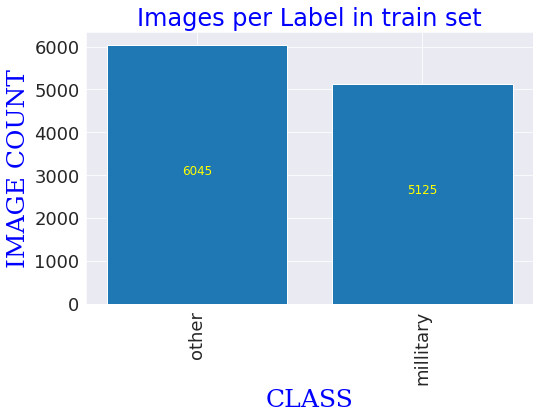

Look at the print out to see the average images width and height.
 then entire the image height to be used to train the model256
 Enter the image width to be used to train the model256
model will be trained with image shape of  ( 256, 256 )

 enter A  to auto balance the train set or enter 
 M to manually balance or hit enter to leave train set unchanged
training data set will be used as is 

Found 11170 validated image filenames belonging to 2 classes.
Found 3491 validated image filenames belonging to 2 classes.
Found 2792 validated image filenames belonging to 2 classes.
Below are some example training images



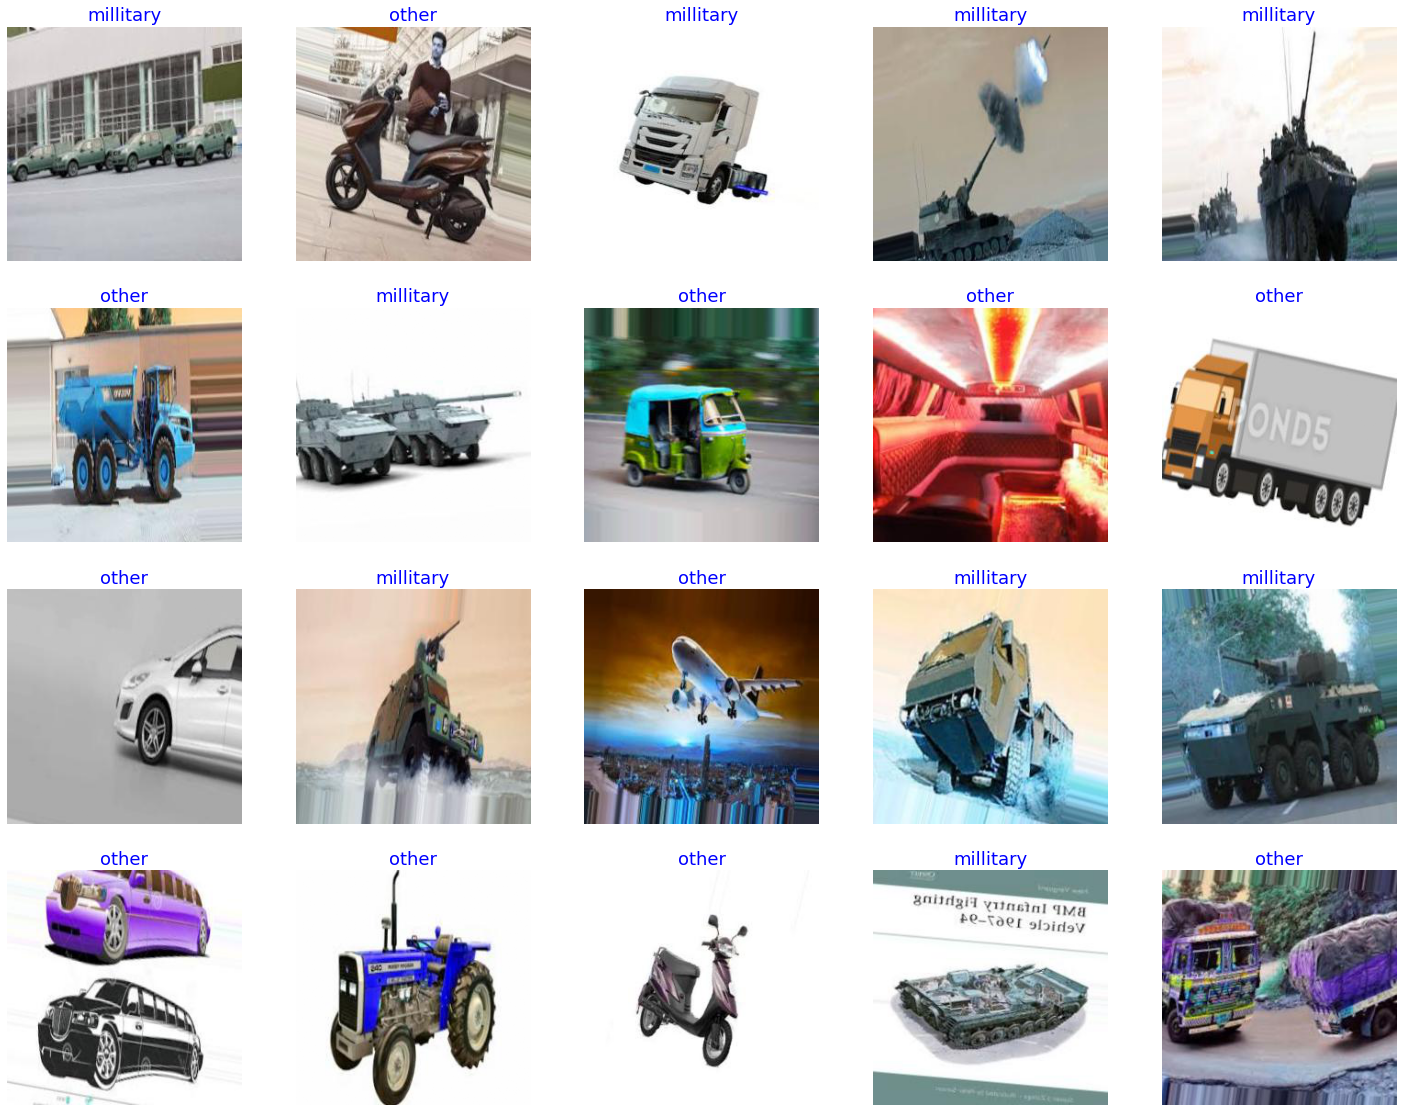

43941136/43941136 [==============================] - 3s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001

Your model will start training. After 10 epochs you will be asked if you wish to halt training by entering H
or enter the number of additional epochs to run, then you will be queired again after those epochs complete.
 To decide look at the % decrease in validation loss if it is less than 2% enter H to halt training
 Note your model is set with the weights from the epoch with lowest validation loss

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/100
  6/559 [..............................] - ETA: 4:18 - loss: 8.7168 - accuracy: 0.6500 - F1_score: 0.6500 - auc: 0.6642

559/559 [==============================] - ETA: 0s - loss: 3.5845 - accuracy: 0.9316 - F1_score: 0.9317 - auc: 0.9754
 validation loss of  1.4840 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

559/559 [==============================] - 314s 518ms/step - loss: 3.5845 - accuracy: 0.9316 - F1_score: 0.9317 - auc: 0.9754 - val_loss: 1.4840 - val_accuracy: 0.9883 - val_F1_score: 0.9883 - val_auc: 0.9991
Epoch 2/100
559/559 [==============================] - ETA: 0s - loss: 0.8759 - accuracy: 0.9772 - F1_score: 0.9772 - auc: 0.9965
 validation loss of  0.4284 is 71.1304 % below lowest loss, saving weights from epoch 2   as best weights

559/559 [==============================] - 286s 512ms/step - loss: 0.8759 - accuracy: 0.9772 - F1_score: 0.9772 - auc: 0.9965 - val_loss: 0.4284 - val_accuracy: 0.9948 - val_F1_score: 0.9949 - val_auc: 0.9997
Epoch 3/100
559/559 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.9868 - F1_score: 0.9868 - au

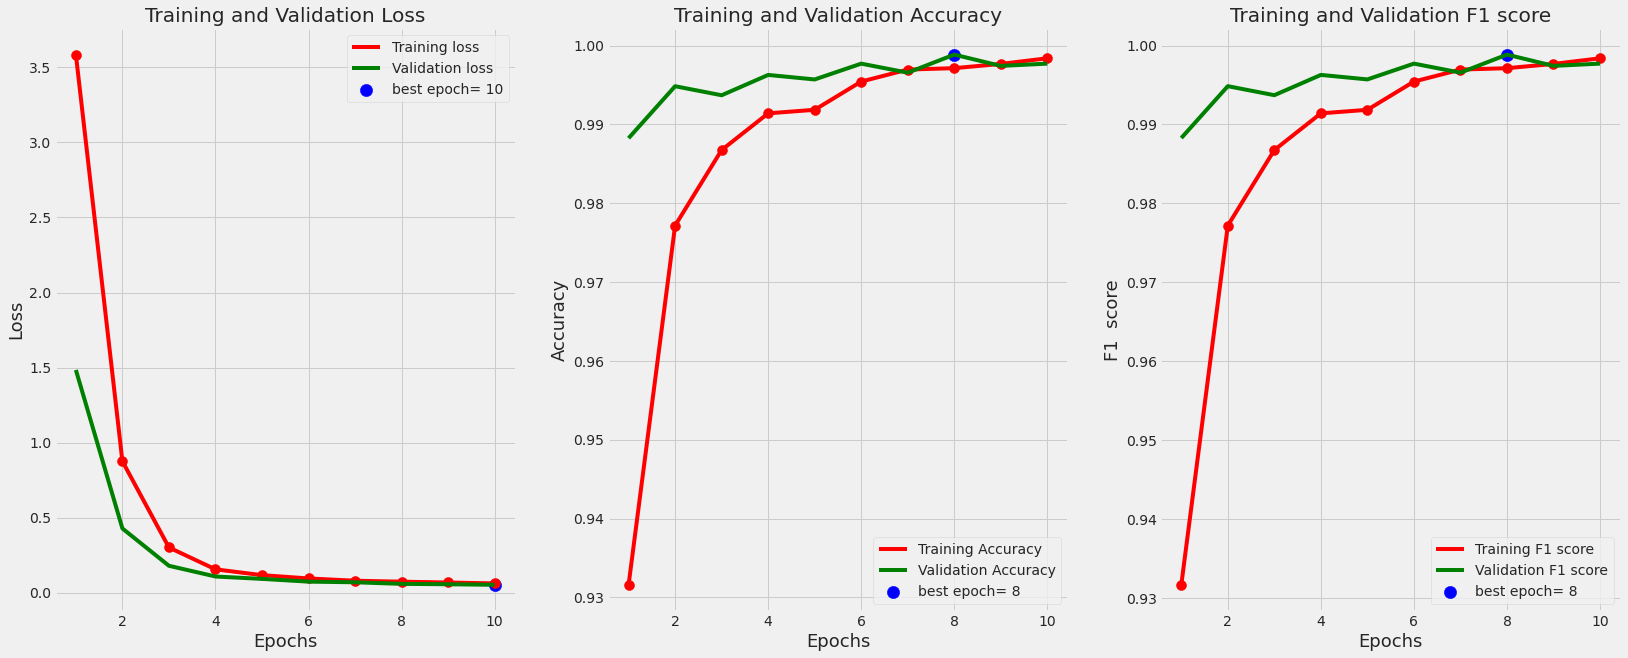

349/349 [==============================] - 18s 44ms/step
there were 11 errors in 2792 tests for an accuracy of  99.61



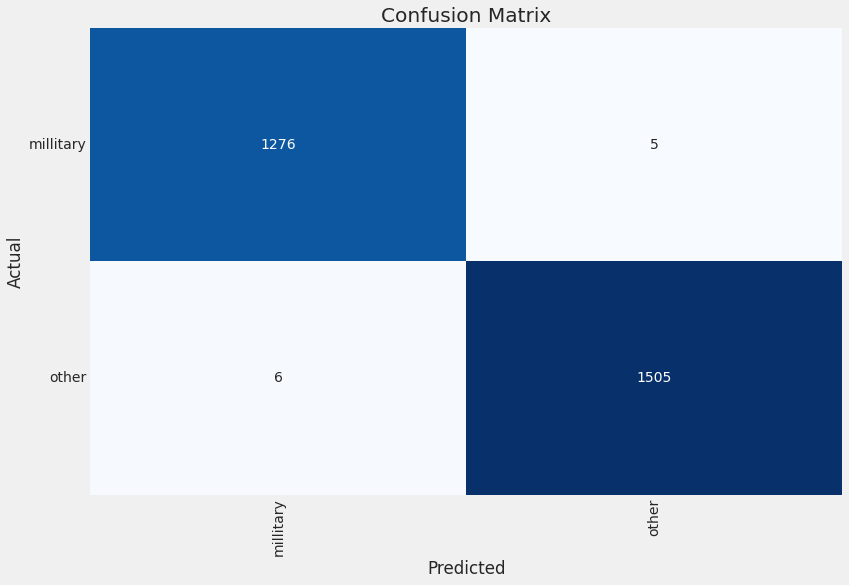

Classification Report:
----------------------
               precision    recall  f1-score   support

   millitary     0.9953    0.9961    0.9957      1281
       other     0.9967    0.9960    0.9964      1511

    accuracy                         0.9961      2792
   macro avg     0.9960    0.9961    0.9960      2792
weighted avg     0.9961    0.9961    0.9961      2792

Below is a list of test files that were miss classified 

                    Test File                                        Predicted as                   
/content/dataset/test/millitary/millitary_0_3022.jpeg-/content/dataset/test/millitary/millitary_0_3022.jpeg                      other                       
/content/dataset/test/millitary/millitary_0_6128.jpeg-/content/dataset/test/millitary/millitary_0_6128.jpeg                      other                       
/content/dataset/test/millitary/millitary_0_6143.jpeg-/content/dataset/test/millitary/millitary_0_6143.jpeg                      other                 

UnboundLocalError: ignored

<Figure size 1080x3600 with 0 Axes>

In [24]:
msg='enter the full path to the working directory where data will be stored.'
working_dir=input(msg)
if 'kaggle' in working_dir:
    delimiter='/'
else:
    delimiter='\\'
msg='Enter the full path to the train directory'
train_dir =input(msg)
msg = 'Enter the full path to the validation directory. If there is no validation directory press enter'
ans=input(msg)
if ans == '':
    valid_dir=None
else:
    valid_dir=ans
msg = 'Enter the full path to the test directory. If there is no test directory press enter'
ans=input(msg)
if ans == '':
    test_dir=None
else:
    test_dir=ans
ftotal, flargest, maxclass = check_dataset_size(train_dir)
msg1= f' the train directory contains {ftotal} files, class {maxclass} has the most images of {flargest} files\n '
msg2='When dealing with very large data sets to save time you may not want to read in all the image files\n'
msg3 ='to limit the maximum number of image files in any class you can enter a limiter value'
msg=msg1 +msg2 + msg3
print_in_color(msg)
msg = 'input a limiter integer value to limit max number of images in a class, for no limit hit enter'
limiter=input(msg)
if limiter == '':
    limiter = None
else:
    limiter=int(limiter)
    msg=f'images will be limited to a maximum of {limiter} images in each class'
    print_in_color(msg)    
train_df, test_df, valid_df, classes, class_count, max_samples, min_samples, have, wave=make_dataframes(train_dir,test_dir, valid_dir, limiter)
msg='Look at the print out to see the average images width and height.\n then entire the image height to be used to train the model'            
img_height=int(input(msg))
msg=' Enter the image width to be used to train the model'            
img_width=int(input(msg))
img_size=(img_height, img_width)
msg=f'model will be trained with image shape of  ( {img_height}, {img_width} )'
print_in_color(msg)
train_df, img_size, classes, class_count = preprocess_dataset(train_df,img_size, max_samples, min_samples, working_dir)
train_gen, test_gen, valid_gen, test_steps= make_gens(20, 'labels', train_df, test_df, valid_df, img_size)
show_image_samples(train_gen )
model = make_model(img_size, .001, mod_num=3)
epochs=100
ask_epoch=10
ask=LR_ASK(model, epochs=epochs,  ask_epoch=ask_epoch)
callbacks=[ask]
msg=f'Your model will start training. After 10 epochs you will be asked if you wish to halt training by entering H\nor enter the number of additional epochs to run, then you will be queired again after those epochs complete.\n To decide look at the % decrease in validation loss if it is less than 2% enter H to halt training\n Note your model is set with the weights from the epoch with lowest validation loss' 
print_in_color (msg) 
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=True,  initial_epoch=0)
tr_plot(history)
errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)
print_errors(error_list, delimiter)
show_misclassification(error_list, error_pred_list, test_gen, delimiter)
msg=f'your trained model will be saved to directory {working_dir} enter a subject for the saved model'
subject=input(msg)
save_model(subject, classes, img_size, f1score, working_dir)
msg='model save nomenclature is directory/subject-number of classes- (img_height, img_width)- F1score.h5'
print_in_color(msg)